# Text classification with the NLTK toolkit and Scikit-learn

***

This project uses the NLTK toolkit and Scikit-learn to build a binary spam filter. We will use the well known spam ham text message dataset from the UCI repository to train and evaluate our model. The first section of the project covers the bag of words model and feature vectorisation using Scikit-Learn. Next, a multinomial naive Bayes model is used to classify messages into Ham and Spam categories. We will cover the basic metrics used to evaluate classifiers: the confusion matrix, precision, recall, F1-score, the precision-recall curve and the ROC curve. 

***

In [2]:
import os
from zipfile import ZipFile
from six.moves import urllib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import string
%matplotlib inline 

In [3]:
DOWNLOAD_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
STORE_PATH = os.path.join("data")
FILE_NAME =  "SMS.zip"

def download_data_from_zip(url=DOWNLOAD_URL, dir_path=STORE_PATH):
    
    #Check if target directory exists. If not, create it. 
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    #Retive and and unpack the download to dir_path
    download_path = os.path.join(dir_path, FILE_NAME)
    urllib.request.urlretrieve(url, download_path)
    SMS_PATH = os.path.join(STORE_PATH,FILE_NAME)
    with ZipFile(SMS_PATH, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
    
download_data_from_zip()

DATA_PATH = os.path.join(STORE_PATH,"SMSSpamCollection.txt")
columns = ['label','text']
SMS_data = pd.read_csv(DATA_PATH, names=columns, delimiter='\t')

In [4]:
print(SMS_data.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
print(SMS_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB
None


There are two columns and no missing values. immediately we see that the text file has a lot of shorthand and punctuation. To deal with this we will normalise the text. To normalise, first remove punctuation and then remove words which often appear in both Ham and Spam messages, these are known as **stopwords**; NLTK provides a large list of stopwords. The transformation steps will be as follows:

 - Split data
 - Remove punctuation
 - Remove stopwords
 - Tokenize

Tokenization is the process of assigning a numerical value to each word in the document. Scikit-learn has multiple classes to do this, one is CountVectorizer which can be used to create a **bag-of-words** model. In the bag-of-words model a document (in this case an SMS message) is converted to a list of words and then the frequency of each word in the document is recorded in a vector: in Scikit-learn this is done by the CountVectorizer class. The frequency of words in the document is used as the feature to classify a document as belonging to one class or another. CountVectorizer does this for an entire collection of documents, **the corpus**, and stores the frequencies of every word in a sparse matrix. Each column is a word and each row is a document. The set of all words in the corpus is the **vocabulary**.

The first step is to split the data into training and test sets.

In [6]:
from sklearn.model_selection import train_test_split

#Split data 
X = SMS_data['text']
y = SMS_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

It is possible to combine the final three transformation steps by using CountVectorizer's analyzer which is capapble of transforming the data before tokenization. We can pass a custom function to analyzer to perform our desired preprocessing. In our case we will write a function to remove punctuation and stopwords, which are imported from NLTK using the NLTK shell. We want the function to return a list of strings for each message.

In [7]:
import nltk
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [8]:
from nltk.corpus import stopwords

def simple_text_normalise(message):
    no_punc = ''.join([char for char in message if char not in string.punctuation])
    no_stopwords = [word.lower() for word in no_punc.split() if word.lower() not in stopwords.words('english')]
    return no_stopwords

#Test the function out 
normalised_df = X_train.apply(simple_text_normalise)
print(normalised_df)


1978    [reply, win, £100, weekly, 2006, fifa, world, ...
3989    [hello, sort, town, already, dont, rush, home,...
3935                [come, guoyang, go, n, tell, u, told]
4078    [hey, sathya, till, dint, meet, even, single, ...
4086    [orange, brings, ringtones, time, chart, heroe...
4919    [sitting, mu, waiting, everyone, get, suite, t...
2268                                    [finish, liao, u]
4696    [urgent, mobile, 07808726822, awarded, £2000, ...
3653                      [probably, still, going, stuff]
70                    [wah, lucky, man, save, money, hee]
4467                                 [hey, u, still, gym]
2418    [oh, lk, tt, den, take, e, one, tt, ends, cine...
2623                                            [ok, lor]
1272    [still, havent, collected, dough, pls, let, kn...
1454                                [stupidits, possible]
831     [u, secret, admirer, reveal, thinks, u, r, spe...
5082    [amazing, rearrange, letters, gives, meaning, ...
1893    [call,

Next we build a pipeline to vectorize the text and fit a multinomial naive Bayes classifier, then evaluate using cross-validation. The Bayes classifier calculates the probability that an instance belongs to the Spam class using Bayes theorem and compares this to a threshold value; if the probablity is above the threshold value the instance is classified as Spam. 

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict


pipeline = Pipeline([('vect',CountVectorizer(analyzer=simple_text_normalise)),('nbm',MultinomialNB())])
predictions = cross_val_predict(pipeline,X_train,y_train,cv=3)

The confusion matrix organises the True Negatives (Ham clasified as Ham), False Negatives (Spam clasified as Ham), False Positives (Ham classified as Spam) and True Positives (Spam classified as Spam) into a grid. From the confusion matrix we can caluclate further evaluation metrics: **precision**, **recall**, **F1-score**, **false positive rate** and **true positive rate**. 

 - Precision: this is the number of true positives divided by the number of all true predictions; TP/(TP+FP). This describes how often the classifier is correct when it predicts positive. High precision limits the number of false positives (limits the number of legitimate messages being clasified as spam). A precision of 1 (FP=0) means the classifier never incorrectly classifies Ham as Spam. 
 
 - Recall: this is the number of true positives divded by the number of true instances; TP/(TP+FN). This describes how often the classifier is correct when the instance truely is positive. High Recall limits the number of False negatives (limites the number of spam messages being classified as legitimate). Recall of 1 (FN=0) means the classifier never incorrecly classifies Spam as Ham. 
 
 - The F1-score: the harmonic mean of precision and recall.
 
 - False positive rate (FPR): how often does the classifier incorrecly classify a message as Spam when it is legitimate; FP/(FP+TN).
 
 - True positive rate (TPR): how often is the classifier correct when it classifies a message as Spam (positive); TP/(TP+FN).

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix_cv = confusion_matrix(y_train,predictions)

def precision_score(confusion_mat):
    return confusion_matrix_cv[1,1]/(confusion_matrix_cv[1,1]+confusion_matrix_cv[0,1])

def recall_score(confusion_matrix_cv):
    return confusion_matrix_cv[1,1]/(confusion_matrix_cv[1,1]+confusion_matrix_cv[1,0])

def f1_score(confusion_mat):
    precision = precision_score(confusion_matrix_cv)
    recall = recall_score(confusion_matrix_cv)
    return 2*precision*recall/(precision+recall)

precision = precision_score(confusion_matrix_cv)
recall = recall_score(confusion_matrix_cv)
f1 = f1_score(confusion_matrix_cv)

print('Confusion matrix:')
print(confusion_matrix_cv)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Confusion matrix:
[[3835   24]
 [  59  539]]
Precision: 0.9573712255772646
Recall: 0.9013377926421404
F1-score: 0.9285099052540913


The confusion matrix can be visualised as a heatmap. 

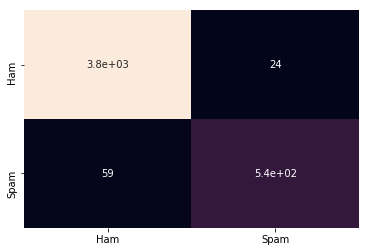

In [12]:
labels = ['Ham','Spam']
ax = sns.heatmap(confusion_matrix_cv,annot=True,xticklabels=labels, yticklabels=labels,cbar=False)

The above metrics are dependent upon the threshold value. A threshold of 0 means all messages are classified as Spam and a threshold of 1 means all messages are classified as Ham. We can calculate the above metrics at different threshold values and plot them against each other in order to visualse the relationship between precision and recall and the FPR and the TPR. These plots are called the precision-recall curve and the receiver operating characteristic. In order to obtrain these curves we need to get the probability that each instance belongs to the Spam class from our classifier. 

In [21]:
#Convert the ham/spam strings into integers 0/1.
def string_to_int(array):
    binary_array = np.zeros(len(array))
    ones = np.argwhere(array == 'spam')
    binary_array[ones] = 1
    return binary_array.astype(int)

#Convert labels into a binary format
binary_labels = string_to_int(y_train.values)

#Get the probabilities using cross_val_predict
train_probabilities = cross_val_predict(pipeline,X_train,y_train,cv=3,method='predict_proba')

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


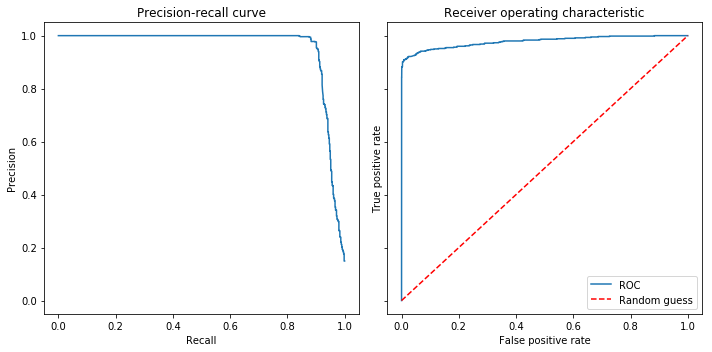

In [27]:
from sklearn.metrics import precision_recall_curve, roc_curve


#Calclate precision, recall, fpr and tpr
precisions, recalls, thresholds = precision_recall_curve(binary_labels,train_probabilities[:,1],pos_label=None)
fpr, tpr, thresholds = roc_curve(binary_labels,train_probabilities[:,1],drop_intermediate=True)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row',figsize=(10,5))
ax[0].plot(recalls,precisions)
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Recall')
ax[0].set_title('Precision-recall curve')
ax[1].plot(fpr,tpr, label='ROC')
ax[1].plot(fpr,fpr,'r--', label='Random guess')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend()
plt.tight_layout()
plt.show()

As the threshold value is changed from 0 to 1 the values of precision, recall, TPR and FPR change. When threshold value is 0, everything is classified as Spam so the number of false negative classifcations is 0 and the true postive rate is 1. When the threshold is 1 everything is classified as Ham and the so the number of false positives and true positives are 0. The optimimum threshold occurs at the turning point of the graphs. However, if you care more about precision than recall, for example, you may want to choose a threshold corresponding to a point away from the turning point. 

The red dotted line on the ROC curve is the characteristic of a classifier that makes random guesses. The area under the red line is 0.5, so an area under the ROC curve larger than 0.5 means the classifier is better than simply making a random guess between Spam and Ham and a score of 1 corresponds to a perfect classifier. Scikit-learn provides a built-in function to calculate the area under curves using the trapezium-rule. 

In [92]:
from sklearn.metrics import auc

AUC_PRC = auc(recalls,precisions)
AUC_ROC = auc(fpr,tpr)
print('Area under PR curve:', AUC_PRC)
print('Area under ROC curve:', AUC_ROC)

Area under PR curve: 0.9359733109943783
Area under ROC curve: 0.9475592824314614


Evaluate classifier on the test set. 

In [29]:
test_predictions = cross_val_predict(pipeline,X_test,y_test,cv=3)

In [31]:
test_confusion_matrix = confusion_matrix(y_test,test_predictions)
test_precision = precision_score(test_confusion_matrix)
test_recall = recall_score(test_confusion_matrix)
test_f1 = f1_score(test_confusion_matrix)

print('Confusion matrix:')
print(test_confusion_matrix)
print('Precision:',test_precision)
print('Recall:', test_recall)
print('F1-score:', test_f1)



Confusion matrix:
[[961   5]
 [ 17 132]]
Precision: 0.9573712255772646
Recall: 0.8859060402684564
F1-score: 0.9285099052540913


The performance of the classifier on the test set is only slightly worse than on the training set. The precision is very similar and the recall is slightly lower.

## Summary and insights

In this notebook we have covered:

- The bag of words model.
- Normalising text documents by removing punctuation and stopwords. 
- Using CountVectoriser to represent a document as a vector of word frequencies, and represent a corpus as a sparse martix of word frequencies. 
- How to build a pipeline to perform tokenization and to fit a multinomial naive Bayes classifier model to training data. 
- How to evaluate a binary classifier using metrics such as precision, recall and the F1-score. 
- How to use Scikit-learn to get classification probabilities from a cross-validated classifier model and use those probabilities to plot the precision-recall curve and the ROC curve. 